In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import io
from PIL import Image, ImageEnhance
from IPython.display import display
from PIL import Image
import os
import random
import cv2
import time

from tensorflow.keras.applications.inception_v3 import preprocess_input

import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import backend, layers, metrics

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception, VGG19, ResNet50, mobilenet_v2, EfficientNetB3, DenseNet121, VGG16,ConvNeXtTiny,ConvNeXtBase,MobileNet
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import zipfile
import os
import shutil

2024-03-14 19:59:37.914240: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-14 19:59:37.914368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-14 19:59:38.065945: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Define paths for input and output data
input_data_path = '/kaggle/input/meglass/MeGlass_ori'
output_data_path = '/kaggle/working/MeGlass'

# Copy or move processed data from input directory to output directory
# Here, we're recursively copying all files and directories
shutil.copytree(input_data_path, output_data_path)

# Confirm that data has been replicated
print("Data replication completed.")

Data replication completed.


In [3]:
# Define paths
import re
input_dir = '/kaggle/working/MeGlass'
output_dir = '/kaggle/working/MeGlass'
# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Group files based on their prefix
file_groups = {}
for file_name in os.listdir(input_dir):
    if os.path.isfile(os.path.join(input_dir, file_name)):
        prefix= file_name.split("@")[0]
        #prefix = file_name[:7]  # Extract the first six characters (0000120_015.jpg) (jhbjh_0004.jpg)
        if prefix not in file_groups:
            file_groups[prefix] = []
        file_groups[prefix].append(file_name)
        
for prefix, files in file_groups.items():
    folder_path = os.path.join(output_dir, prefix)
    os.makedirs(folder_path, exist_ok=True)
    c=0
    for file_name in files:
        c+=1
        if c>9 and c<100:
            edit_file = prefix+'_00'+str(c)+'.jpg'
        elif c<=9:
            edit_file = prefix+'_000'+str(c)+'.jpg'
        else:
            edit_file = prefix+'_0'+str(c)+'.jpg'
        source_path = os.path.join(input_dir, file_name)
        destination_path = os.path.join(folder_path, edit_file)
        shutil.move(source_path, destination_path)

print("Files moved successfully.")

Files moved successfully.


In [4]:
# Setting random seeds to enable consistency while testing.
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

ROOT = r"/kaggle/working/MeGlass"

def read_image(index):
#     path = os.path.join(ROOT, index[0], index[1])
    if(index[1]>9 and index[1]<100):
        path = os.path.join(ROOT, index[0], index[0]+'_00'+str(index[1])+'.jpg')
    elif(index[1]<=9):
        path = os.path.join(ROOT, index[0], index[0]+'_000'+str(index[1])+'.jpg')
    else:
        path = os.path.join(ROOT, index[0], index[0]+'_0'+str(index[1])+'.jpg')
    
    image = cv2.imread(path)
    #print(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.array(Image.fromarray(image).resize((128, 128)))
    #image = image.reshape(image.shape[0], 128, 128, 3)
    
    return image

In [5]:
def split_dataset(directory, split=0.9):
    folders = os.listdir(directory)
    num_train = int(len(folders)*split)
    
    random.shuffle(folders)
    
    train_list, test_list = {}, {}
    
    # Creating Train-list
    for folder in folders[:num_train]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        train_list[folder] = num_files
    
    # Creating Test-list
    for folder in folders[num_train:]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        test_list[folder] = num_files  
    
    return train_list, test_list

train_list, test_list = split_dataset(ROOT, split=0.9)
print("Length of training list:", len(train_list))
print("Length of testing list :", len(test_list))

# train_list, test list contains the folder names along with the number of files in the folder.
print("\nTest List:", test_list)

Length of training list: 1408
Length of testing list : 157

Test List: {'7997397': 187, '72675636': 212, '52853124': 17, '39311234': 71, '74798093': 9, '33906853': 7, '35034353918': 8, '34784158': 30, '27656042': 34, '31437555': 6, '9293356': 46, '44124373856': 6, '13334322': 11, '33917177': 46, '12257577': 9, '55772206': 146, '19323926': 25, '46787051': 9, '13905012': 6, '9710088': 12, '24905543': 16, '12999139': 131, '45057549': 8, '57225509': 43, '110433537': 5, '33419637': 16, '8101189': 34, '21099071': 11, '35355994': 4, '69442051': 25, '46602640': 35, '56414187': 25, '51035647549': 8, '10175970': 9, '26104563': 10, '42323477': 8, '86197159': 20, '105700383': 9, '83101182': 19, '21077319': 33, '25512362': 8, '63696913': 18, '61942787': 12, '85772145': 36, '24203582': 10, '90827594': 6, '99511498': 5, '99902322': 13, '53864689': 32, '63443117': 7, '91814503': 21, '54876474': 63, '7270254': 15, '8482572': 8, '96056340': 15, '11880483': 8, '91462522': 9, '61424990': 11, '51039663': 2

In [6]:
def create_triplets(directory, folder_list, max_files=4):
    triplets = []
    folders = list(folder_list.keys())

    for folder in folders:
        path = os.path.join(directory, folder)
        files = list(os.listdir(path))[:max_files]
        num_files = len(files)

        for i in range(1,num_files):
            for j in range(i+1, num_files):
                anchor = (folder, i)
                positive = (folder, j)

                neg_folder = folder
                while neg_folder == folder:
                    neg_folder = random.choice(folders)
                neg_file = random.randint(1, folder_list[neg_folder])
                negative = (neg_folder, neg_file)

                triplets.append((anchor, positive, negative))

    random.shuffle(triplets)
    return triplets

In [7]:
train_triplet = create_triplets(ROOT, train_list)
test_triplet  = create_triplets(ROOT, test_list)

print("Number of training triplets:", len(train_triplet))
print("Number of testing triplets :", len(test_triplet))

print("\nExamples of triplets:")
for i in range(10):
    print(train_triplet[i])

Number of training triplets: 4224
Number of testing triplets : 471

Examples of triplets:
(('96556957', 2), ('96556957', 3), ('41468763', 4))
(('45919548', 2), ('45919548', 3), ('65947802', 7))
(('25803256', 2), ('25803256', 3), ('21365482', 1))
(('23504336', 1), ('23504336', 3), ('10582933', 6))
(('13491639', 1), ('13491639', 3), ('23478981', 4))
(('40284210', 1), ('40284210', 3), ('16090836', 6))
(('69072483', 1), ('69072483', 3), ('50883823', 2))
(('23672919', 2), ('23672919', 3), ('44112235', 7))
(('16577770', 1), ('16577770', 3), ('54251153', 27))
(('91605789', 1), ('91605789', 2), ('8353488', 18))


In [8]:
from PIL import Image
def get_batch(triplet_list, batch_size=256, preprocess=True):
    batch_steps = len(triplet_list)//batch_size

    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []

        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            anchor.append(read_image(a))
            positive.append(read_image(p))
            negative.append(read_image(n))
            j+=1

        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)

        #print("Original shapes:", anchor.shape, positive.shape, negative.shape)

        # Resize images to (128, 128)
#         anchor_resized = np.array([np.array(Image.fromarray(img).resize((128, 128))) for img in anchor])
#         positive_resized = np.array([np.array(Image.fromarray(img).resize((128, 128))) for img in positive])
#         negative_resized = np.array([np.array(Image.fromarray(img).resize((128, 128))) for img in negative])

#         # Reshape
#         anchor = anchor_resized.reshape(anchor_resized.shape[0], 128, 128, 3)
#         positive = positive_resized.reshape(positive_resized.shape[0], 128, 128, 3)
#         negative = negative_resized.reshape(negative_resized.shape[0], 128, 128, 3)
        #print("Reshaped shapes:", anchor.shape, positive.shape, negative.shape)

        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)

        yield ([anchor, positive, negative])

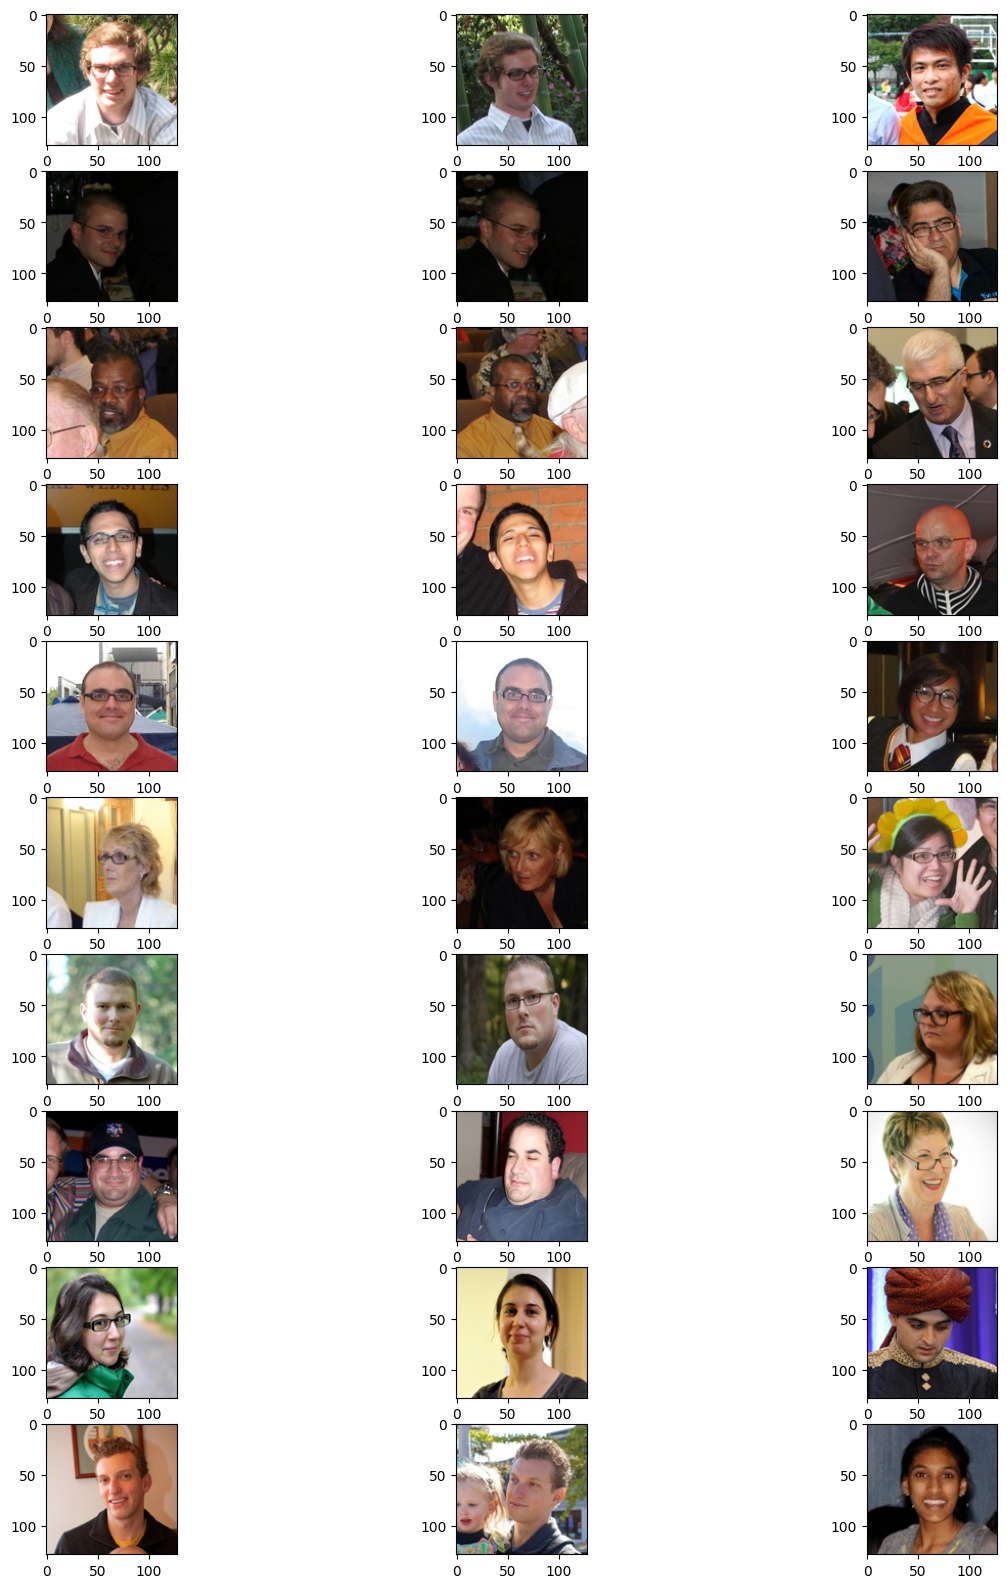

In [9]:
import matplotlib. pyplot as plt
num_plots = 10

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch(train_triplet, batch_size=num_plots, preprocess=False):
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        i+=1
    break

In [10]:
def get_encoder(input_shape):
    """ Returns the image encoding model """

    pretrained_model =Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )

    for i in range(len(pretrained_model.layers)-27):
        pretrained_model.layers[i].trainable = False

    encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")
    return encode_model

In [11]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


def get_siamese_network(input_shape = (128, 128, 3)):
    encoder = get_encoder(input_shape)

    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")

    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)

    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )

    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
         outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network()
siamese_network.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Anchor_Input (InputLayer)   [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Positive_Input (InputLayer  [(None, 128, 128, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 Negative_Input (InputLayer  [(None, 128, 128, 3)]        0         []                            
 )                                                                                                
                   

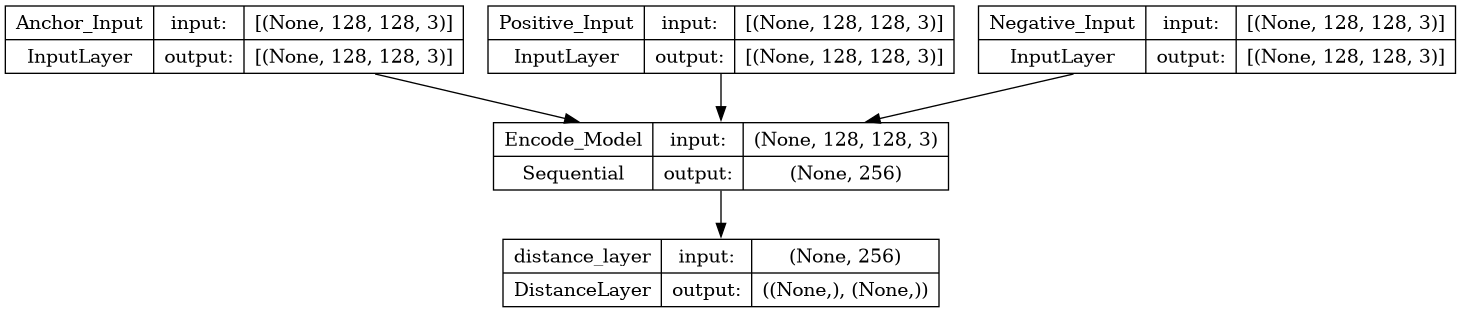

In [12]:
plot_model(siamese_network, show_shapes=True, show_layer_names=True)

In [13]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.4):
        super(SiameseModel, self).__init__()

        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}
    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [14]:
siamese_model = SiameseModel(siamese_network)

optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)

In [15]:
def test_on_triplets(batch_size = 256):
    pos_scores, neg_scores = [], []

    for data in get_batch(test_triplet, batch_size=batch_size):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])

    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)

#   print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [16]:
save_all = False
epochs = 10
batch_size = 256

max_acc = 0
train_loss = []
test_metrics = []
accuracy_list = []
counter=0

for epoch in range(1, epochs+1):
    t = time.time()
    # Training the model on train data
    epoch_loss = []
    for data in get_batch(train_triplet, batch_size=batch_size):
        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)

    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")
    
    # Testing the model on test data
    metric = test_on_triplets(batch_size=batch_size)
    test_metrics.append(metric)
    accuracy = metric[0]
    print(f"Accuracy    = {accuracy}")
    
    # Saving the model weights
    if save_all or accuracy>=max_acc:
        siamese_model.save_weights("siamese_model")
        max_acc = accuracy
#     accuracy_list = np.append(accuracy_list,accuracy)
#     if epoch != 1:
#         if accuracy_list[epoch-1] < accuracy_list[epoch-2] and counter<3:
#             counter+=1
#     if counter>=3:
#         break

# Saving the model after all epochs run
#siamese_model.save_weights("siamese_model-final")
#siamese_model.save('kaggle/working/VGG16_model.tf')

I0000 00:00:1710446810.451939      86 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



EPOCH: 1 	 (Epoch done in 434 sec)
Loss on train    = 1.06839
7/7 [==============================] - 4s 190ms/step
Accuracy    = 0.7664543524416136

EPOCH: 2 	 (Epoch done in 381 sec)
Loss on train    = 0.78635
7/7 [==============================] - 1s 76ms/step
Accuracy    = 0.7791932059447984

EPOCH: 3 	 (Epoch done in 383 sec)
Loss on train    = 0.69262
7/7 [==============================] - 1s 75ms/step
Accuracy    = 0.7600849256900213

EPOCH: 4 	 (Epoch done in 377 sec)
Loss on train    = 0.63605
7/7 [==============================] - 1s 77ms/step
Accuracy    = 0.7961783439490446

EPOCH: 5 	 (Epoch done in 378 sec)
Loss on train    = 0.55934
7/7 [==============================] - 1s 78ms/step
Accuracy    = 0.8110403397027601

EPOCH: 6 	 (Epoch done in 381 sec)
Loss on train    = 0.49603
8/8 [==============================] - 1s 79ms/step

EPOCH: 7 	 (Epoch done in 380 sec)
Loss on train    = 0.45939
7/7 [==============================] - 0s 76ms/step
Accuracy    = 0.7961783439490

In [17]:

# Replace 'your_folder' and 'your_image.jpg' with your actual folder and file names
image_path = '/kaggle/working/MeGlass/8037877/8037877_0001.jpg'
image = cv2.imread(image_path)
#print(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = np.array(Image.fromarray(image).resize((128, 128)))
# Get the dimensions of the image
height, width, channels = image.shape

print("Image dimensions - Height: {}, Width: {}, Channels: {}".format(height, width, channels))
# Open the image using PIL
#img = Image.open(image_path)


Image dimensions - Height: 128, Width: 128, Channels: 3


In [18]:
def extract_encoder(model):
    encoder = get_encoder((128, 128, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)
encoder.save_weights("VGG16encoder_lfw_casia_without_aug_delete1_max4_100epochs_early_printtrain")
encoder.summary()

Model: "Encode_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_9 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 lambda_1 (Lambda)           (None, 256)               0         
                                                      

In [19]:
def classify_images(face_list1, face_list2, threshold=1.1):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    #print(distance)
    return prediction

In [20]:
def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)
    
    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

7/7 [==============================] - 0s 23ms/step

Accuracy of model: 0.7367303609341825



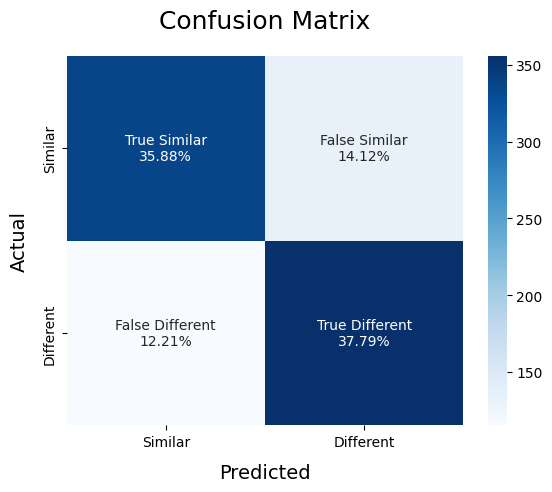

In [21]:
pos_list = np.array([])
neg_list = np.array([])
zero_list = np.array([])

for data in get_batch(test_triplet, batch_size=256):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))

# for data in get_batch(test_triplet, batch_size=256):
#     a, p, n = data
#     pos_list = np.append(pos_list, classify_without_threshold(a, p,n))
#     print(pos_list)
# for i in pos_list:
#     if i==0:
#         zero_list = np.append(zero_list, i)    
# print(len(zero_list))
# print(len(pos_list))
ModelMetrics(pos_list, neg_list)

In [22]:
# pos_list_train = np.array([])
# neg_list_train = np.array([])
# for i in range(50):
#     a,p,n = train_triplet[i]
#     pos_list_train = np.append(pos_list_train, classify_images(a, p))
#     neg_list_train = np.append(neg_list_train, classify_images(a, n))
pos_list_train = np.array([])
neg_list_train = np.array([])
for data in get_batch(train_triplet, batch_size=256):
    a, p, n = data
    pos_list_train = np.append(pos_list_train, classify_images(a, p))
    neg_list_train = np.append(neg_list_train, classify_images(a, n))
#     pos_list_train = np.append(pos_list_train, classify_without_threshold(a, p,n))
#     print(pos_list_train)
#     print('------------------------------------')
#     print(neg_list_train)
# acc2 = np.array([0]*len(pos_list_train))
# print(len(acc2))
# print(len(pos_list_train))
ModelMetrics(pos_list_train, neg_list_train)

8/8 [==============================] - 0s 24ms/step


KeyboardInterrupt: 

In [ ]:
#siamese_model.save("VGG16_model_lfw_casia_meglass_without_aug_delete1_max4_10epochs_early.h5")
#siamese_model.save('kaggle/working/VGG16_model.tf')
encoder.save("Xception_encoder_lfw_casia_meglass_without_aug_delete1_max4_10epochs_early_margin14.h5")
!zip -r Xception_encoder_lfw_casia_meglass_without_aug_delete1_max4_10epochs_early_margin14.zip /kaggle/working/Xception_encoder_lfw_casia_meglass_without_aug_delete1_max4_10epochs_early_margin14.h5
%cd /kaggle/working/Xception_encoder_lfw_casia_meglass_without_aug_delete1_max4_10epochs_early_margin14.zip
from IPython.display import FileLink
FileLink(r'Xception_encoder_lfw_casia_meglass_without_aug_delete1_max4_10epochs_early_margin14.zip')